# **1. Import Libraries**

In [1]:
%pip install pandas numpy seaborn matplotlib scikit-learn lightgbm optuna

Defaulting to user installation because normal site-packages is not writeable

   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------- ----------------------------- 1/4 [colorlog]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import zipfile
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

warnings.filterwarnings('ignore')

# **2. Extract datasets**

In [4]:
with zipfile.ZipFile("loan-approval-quantitativedata.zip", "r") as zip_ref:
    zip_ref.extractall("loan_data")

# **3. Load datasets**

In [5]:
train_df = pd.read_csv('loan_data/train.csv')
test_df = pd.read_csv('loan_data/test.csv')

# **4. Clean column names**

In [6]:
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

print("Columns in train_df:", train_df.columns.tolist())
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

Columns in train_df: ['id', 'person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'loan_status']
Train Shape: (58645, 13)
Test Shape: (39098, 12)


# **5. Check and visualize missing values**

In [7]:
print("\nMissing values in training set:")
print(train_df.isnull().sum())

target_col = 'loan_status'


Missing values in training set:
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


# **6. Encode target if it's Y/N**

In [8]:
if train_df[target_col].dtype == 'object':
    train_df[target_col] = train_df[target_col].map({'Y': 1, 'N': 0})

# **7. Fill missing numerical values with median**

In [9]:
for col in train_df.select_dtypes(include=np.number).columns:
    train_df[col].fillna(train_df[col].median(), inplace=True)
    if col in test_df.columns:
        test_df[col].fillna(test_df[col].median(), inplace=True)

### **8. Fill missing categorical values with mode**

In [10]:
for col in train_df.select_dtypes(include='object').columns:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)
    if col in test_df.columns:
        test_df[col].fillna(train_df[col].mode()[0], inplace=True)

# **9. Correlation Heatmap**

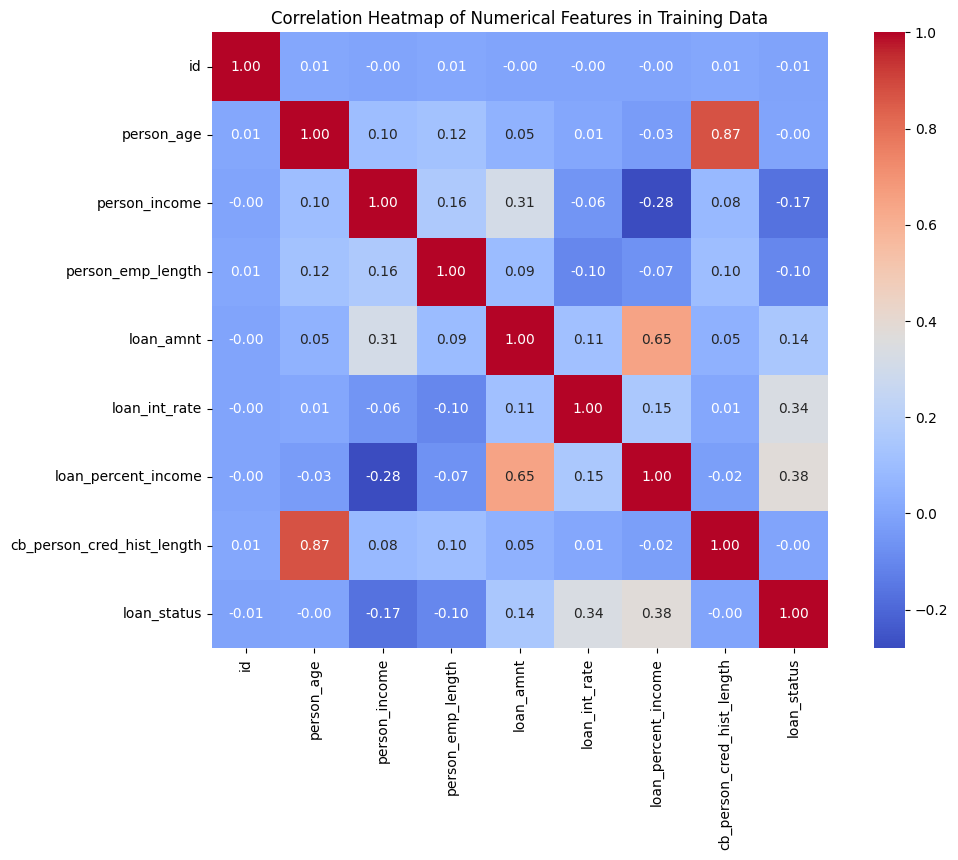

In [11]:
corr_matrix = train_df.select_dtypes(include=np.number).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title("Correlation Heatmap of Numerical Features in Training Data")
plt.show()

# **10. One-hot encoding for categorical features**

In [12]:
X_train_all = pd.get_dummies(train_df.drop(target_col, axis=1))
X_test_all = pd.get_dummies(test_df)

# **11. Align columns of train and test sets after encoding**

In [ ]:
X_train_all, X_test_all = X_train_all.align(X_test_all, join='left', axis=1, fill_value=0)

y = train_df[target_col]

# **12. Train-validation split**

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y, test_size=0.2, random_state=42, stratify=y
)

# **13. Optuna objective function**

In [15]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'is_unbalance': True,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    model = lgb.train(
        param,
        dtrain,
        valid_sets=[dval],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)]
    )

    preds = model.predict(X_val)
    auc = roc_auc_score(y_val, preds)
    return auc

# **14. Run Optuna study to find best hyperparameters**

In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\nBest trial:")
trial = study.best_trial
print(f"  AUC: {trial.value}")
print("  Best params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'is_unbalance': True,
})

[I 2025-09-21 13:49:32,921] A new study created in memory with name: no-name-14292869-7512-48cf-b4a3-46b8732f1c4a


Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:34,241] Trial 0 finished with value: 0.9503749435218438 and parameters: {'num_leaves': 52, 'max_depth': 12, 'learning_rate': 0.02784609405607803, 'feature_fraction': 0.8388788088414416, 'bagging_fraction': 0.6735201323041856, 'bagging_freq': 7, 'min_child_samples': 44, 'lambda_l1': 0.04802778793247079, 'lambda_l2': 0.11576968027797968}. Best is trial 0 with value: 0.9503749435218438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.950375
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:35,623] Trial 1 finished with value: 0.9442110410851426 and parameters: {'num_leaves': 77, 'max_depth': 10, 'learning_rate': 0.011766709801500675, 'feature_fraction': 0.7756706058073299, 'bagging_fraction': 0.6427394761248658, 'bagging_freq': 10, 'min_child_samples': 72, 'lambda_l1': 6.256479054820228e-06, 'lambda_l2': 0.36627457408499625}. Best is trial 0 with value: 0.9503749435218438.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.944211
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:38,470] Trial 2 finished with value: 0.9486542572475091 and parameters: {'num_leaves': 26, 'max_depth': 6, 'learning_rate': 0.05063096035834229, 'feature_fraction': 0.8358357618322941, 'bagging_fraction': 0.7978772484742485, 'bagging_freq': 10, 'min_child_samples': 86, 'lambda_l1': 0.002104627189688297, 'lambda_l2': 1.7012289094219188}. Best is trial 0 with value: 0.9503749435218438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.948654
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:39,708] Trial 3 finished with value: 0.9388746515320091 and parameters: {'num_leaves': 32, 'max_depth': 8, 'learning_rate': 0.010926204352601585, 'feature_fraction': 0.7205081594407922, 'bagging_fraction': 0.9382230364750149, 'bagging_freq': 3, 'min_child_samples': 39, 'lambda_l1': 0.01517604912997615, 'lambda_l2': 1.2874560215099902e-08}. Best is trial 0 with value: 0.9503749435218438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.938875
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:40,699] Trial 4 finished with value: 0.9489746424240693 and parameters: {'num_leaves': 33, 'max_depth': 6, 'learning_rate': 0.05611475627865697, 'feature_fraction': 0.7008627620664469, 'bagging_fraction': 0.6709524050084287, 'bagging_freq': 10, 'min_child_samples': 61, 'lambda_l1': 1.2705537504896317e-07, 'lambda_l2': 0.0005271675475944551}. Best is trial 0 with value: 0.9503749435218438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.948975
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:41,998] Trial 5 finished with value: 0.9346821120657581 and parameters: {'num_leaves': 108, 'max_depth': 7, 'learning_rate': 0.0060409708724829805, 'feature_fraction': 0.8215897826890503, 'bagging_fraction': 0.8819392093382064, 'bagging_freq': 3, 'min_child_samples': 99, 'lambda_l1': 0.4568013533495365, 'lambda_l2': 5.565751108140759e-05}. Best is trial 0 with value: 0.9503749435218438.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.934682
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:43,043] Trial 6 finished with value: 0.9418547039532627 and parameters: {'num_leaves': 79, 'max_depth': 6, 'learning_rate': 0.027213515102660634, 'feature_fraction': 0.8026341722497976, 'bagging_fraction': 0.7377067351201375, 'bagging_freq': 6, 'min_child_samples': 47, 'lambda_l1': 1.1641870758806631e-07, 'lambda_l2': 0.3425940501066693}. Best is trial 0 with value: 0.9503749435218438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.941855
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:44,480] Trial 7 finished with value: 0.9509607388265521 and parameters: {'num_leaves': 51, 'max_depth': 11, 'learning_rate': 0.039349055512686956, 'feature_fraction': 0.9432380766484089, 'bagging_fraction': 0.9739449974840912, 'bagging_freq': 9, 'min_child_samples': 79, 'lambda_l1': 6.299829275939852e-06, 'lambda_l2': 8.819557151736194e-08}. Best is trial 7 with value: 0.9509607388265521.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.950961
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:45,743] Trial 8 finished with value: 0.9455589268822927 and parameters: {'num_leaves': 45, 'max_depth': 12, 'learning_rate': 0.014438930612640706, 'feature_fraction': 0.8818129032417397, 'bagging_fraction': 0.7529692175298275, 'bagging_freq': 6, 'min_child_samples': 51, 'lambda_l1': 0.16647350464901675, 'lambda_l2': 0.00037227251039058515}. Best is trial 7 with value: 0.9509607388265521.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.945559
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:46,858] Trial 9 finished with value: 0.9422951591597599 and parameters: {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.014177898929337488, 'feature_fraction': 0.8061994073116773, 'bagging_fraction': 0.7381741829183548, 'bagging_freq': 7, 'min_child_samples': 36, 'lambda_l1': 0.00954527458893171, 'lambda_l2': 0.0034508995374581053}. Best is trial 7 with value: 0.9509607388265521.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.942295
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:47,570] Trial 10 finished with value: 0.9396786504533433 and parameters: {'num_leaves': 135, 'max_depth': 3, 'learning_rate': 0.08929303675736457, 'feature_fraction': 0.9983250792840593, 'bagging_fraction': 0.9937381903962147, 'bagging_freq': 1, 'min_child_samples': 21, 'lambda_l1': 1.678431541313441e-05, 'lambda_l2': 2.426962787030844e-08}. Best is trial 7 with value: 0.9509607388265521.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.939679
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:50,321] Trial 11 finished with value: 0.9484685267103729 and parameters: {'num_leaves': 62, 'max_depth': 12, 'learning_rate': 0.030378154188194534, 'feature_fraction': 0.9492460583812681, 'bagging_fraction': 0.6046617266209617, 'bagging_freq': 8, 'min_child_samples': 69, 'lambda_l1': 6.25925463434737e-05, 'lambda_l2': 2.1004533631962435e-06}. Best is trial 7 with value: 0.9509607388265521.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.948469
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:52,035] Trial 12 finished with value: 0.9497547404445508 and parameters: {'num_leaves': 58, 'max_depth': 10, 'learning_rate': 0.03861712429567456, 'feature_fraction': 0.9111980711338632, 'bagging_fraction': 0.8723523345981719, 'bagging_freq': 8, 'min_child_samples': 6, 'lambda_l1': 8.400190352446883, 'lambda_l2': 0.01039960344049306}. Best is trial 7 with value: 0.9509607388265521.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.949755
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:53,687] Trial 13 finished with value: 0.9494100971930282 and parameters: {'num_leaves': 106, 'max_depth': 12, 'learning_rate': 0.021032036039410947, 'feature_fraction': 0.6034545825541425, 'bagging_fraction': 0.8538213020322464, 'bagging_freq': 8, 'min_child_samples': 83, 'lambda_l1': 2.02681572797486e-06, 'lambda_l2': 5.422938154359795e-06}. Best is trial 7 with value: 0.9509607388265521.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.94941
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:55,071] Trial 14 finished with value: 0.9543060017751553 and parameters: {'num_leaves': 57, 'max_depth': 9, 'learning_rate': 0.076000709001955, 'feature_fraction': 0.9970822526351438, 'bagging_fraction': 0.9674213142057737, 'bagging_freq': 4, 'min_child_samples': 29, 'lambda_l1': 0.0004598937941915013, 'lambda_l2': 9.544684685380563}. Best is trial 14 with value: 0.9543060017751553.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.954306
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:56,525] Trial 15 finished with value: 0.9527388408390496 and parameters: {'num_leaves': 91, 'max_depth': 9, 'learning_rate': 0.09767868457655185, 'feature_fraction': 0.9790627368028619, 'bagging_fraction': 0.9950760008998698, 'bagging_freq': 4, 'min_child_samples': 22, 'lambda_l1': 0.0003000970705473234, 'lambda_l2': 1.2456574686996947e-07}. Best is trial 14 with value: 0.9543060017751553.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.952739
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:57,931] Trial 16 finished with value: 0.954573406125417 and parameters: {'num_leaves': 106, 'max_depth': 8, 'learning_rate': 0.09623691117005977, 'feature_fraction': 0.9942385877098175, 'bagging_fraction': 0.9372012484581872, 'bagging_freq': 4, 'min_child_samples': 23, 'lambda_l1': 0.0007852453531596871, 'lambda_l2': 8.466112523339905}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.954573
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:58,754] Trial 17 finished with value: 0.9441933907312128 and parameters: {'num_leaves': 147, 'max_depth': 4, 'learning_rate': 0.06894465868333442, 'feature_fraction': 0.899190448507777, 'bagging_fraction': 0.9265439007058952, 'bagging_freq': 4, 'min_child_samples': 27, 'lambda_l1': 0.0005310318915565847, 'lambda_l2': 9.167928074529007}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.944193
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:49:59,886] Trial 18 finished with value: 0.9520553881797992 and parameters: {'num_leaves': 120, 'max_depth': 8, 'learning_rate': 0.070584767845387, 'feature_fraction': 0.9509969829592049, 'bagging_fraction': 0.9256687560154199, 'bagging_freq': 1, 'min_child_samples': 5, 'lambda_l1': 0.00012609796094950967, 'lambda_l2': 9.250179935824383}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.952055
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.953315


[I 2025-09-21 13:50:02,216] Trial 19 finished with value: 0.9533153793814101 and parameters: {'num_leaves': 95, 'max_depth': 9, 'learning_rate': 0.09823798388393129, 'feature_fraction': 0.9917209485046051, 'bagging_fraction': 0.8296106863273035, 'bagging_freq': 4, 'min_child_samples': 14, 'lambda_l1': 0.002654723257558913, 'lambda_l2': 0.02297729966379703}. Best is trial 16 with value: 0.954573406125417.


Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:04,378] Trial 20 finished with value: 0.9521450388813784 and parameters: {'num_leaves': 72, 'max_depth': 7, 'learning_rate': 0.06754588719169388, 'feature_fraction': 0.8788913313171638, 'bagging_fraction': 0.9515199142147428, 'bagging_freq': 2, 'min_child_samples': 32, 'lambda_l1': 6.439066903278684e-07, 'lambda_l2': 1.4419289044349897}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.952145
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:05,840] Trial 21 finished with value: 0.9520959869702883 and parameters: {'num_leaves': 94, 'max_depth': 9, 'learning_rate': 0.09887572316038881, 'feature_fraction': 0.9862857493768187, 'bagging_fraction': 0.8234095077022947, 'bagging_freq': 5, 'min_child_samples': 15, 'lambda_l1': 0.001958621345584271, 'lambda_l2': 0.02979507747843444}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.952096
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:07,389] Trial 22 finished with value: 0.9523076126303909 and parameters: {'num_leaves': 105, 'max_depth': 9, 'learning_rate': 0.07663015964193037, 'feature_fraction': 0.9270372185770424, 'bagging_fraction': 0.9039268925699584, 'bagging_freq': 4, 'min_child_samples': 18, 'lambda_l1': 0.0019831242651858656, 'lambda_l2': 0.03873225285106109}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.952308
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:08,785] Trial 23 finished with value: 0.9502947579341764 and parameters: {'num_leaves': 120, 'max_depth': 8, 'learning_rate': 0.05002053578804179, 'feature_fraction': 0.9733822938164217, 'bagging_fraction': 0.8264493255255092, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 1.4059240876230538e-08, 'lambda_l2': 1.4268179042762372}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.950295
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:10,301] Trial 24 finished with value: 0.9494436715593567 and parameters: {'num_leaves': 92, 'max_depth': 9, 'learning_rate': 0.05757193244774027, 'feature_fraction': 0.9957018471546075, 'bagging_fraction': 0.9570496503372737, 'bagging_freq': 3, 'min_child_samples': 29, 'lambda_l1': 5.129057306244571e-05, 'lambda_l2': 0.0026994016482830077}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.949444
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:11,624] Trial 25 finished with value: 0.9471514471801998 and parameters: {'num_leaves': 119, 'max_depth': 7, 'learning_rate': 0.03925541507130497, 'feature_fraction': 0.8655372137042845, 'bagging_fraction': 0.7793309560684454, 'bagging_freq': 2, 'min_child_samples': 25, 'lambda_l1': 0.0006329435039820974, 'lambda_l2': 0.22205867370251808}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.947151
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:12,561] Trial 26 finished with value: 0.9494938247572853 and parameters: {'num_leaves': 100, 'max_depth': 5, 'learning_rate': 0.07696701607349034, 'feature_fraction': 0.9561697577620071, 'bagging_fraction': 0.8978826112460326, 'bagging_freq': 5, 'min_child_samples': 11, 'lambda_l1': 0.010107222853305942, 'lambda_l2': 9.582261892037087}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.949494
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.953809


[I 2025-09-21 13:50:14,412] Trial 27 finished with value: 0.9538091130592974 and parameters: {'num_leaves': 67, 'max_depth': 11, 'learning_rate': 0.08942311260309574, 'feature_fraction': 0.9204359370028947, 'bagging_fraction': 0.8445862030938404, 'bagging_freq': 4, 'min_child_samples': 38, 'lambda_l1': 0.9019126720830419, 'lambda_l2': 1.485485180150232}. Best is trial 16 with value: 0.954573406125417.


Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:17,252] Trial 28 finished with value: 0.9406220663355663 and parameters: {'num_leaves': 66, 'max_depth': 11, 'learning_rate': 0.006227472087701335, 'feature_fraction': 0.9171237571786658, 'bagging_fraction': 0.8567345573796894, 'bagging_freq': 2, 'min_child_samples': 58, 'lambda_l1': 1.5783334022087274, 'lambda_l2': 0.849313693872037}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.940622
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:18,593] Trial 29 finished with value: 0.9533591629743794 and parameters: {'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.04719079833812466, 'feature_fraction': 0.8525142275520677, 'bagging_fraction': 0.9101841378500188, 'bagging_freq': 6, 'min_child_samples': 42, 'lambda_l1': 0.08462744905121167, 'lambda_l2': 0.09187991763850081}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.953359
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:20,071] Trial 30 finished with value: 0.953819292521429 and parameters: {'num_leaves': 70, 'max_depth': 10, 'learning_rate': 0.06294384577115517, 'feature_fraction': 0.9341026249967183, 'bagging_fraction': 0.9725123389949495, 'bagging_freq': 3, 'min_child_samples': 35, 'lambda_l1': 6.780150856982005, 'lambda_l2': 3.0049108392084753}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.953819
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:22,479] Trial 31 finished with value: 0.9540136547662207 and parameters: {'num_leaves': 80, 'max_depth': 10, 'learning_rate': 0.08124980387460816, 'feature_fraction': 0.9335356828396459, 'bagging_fraction': 0.9737834267156589, 'bagging_freq': 3, 'min_child_samples': 35, 'lambda_l1': 6.913002498871503, 'lambda_l2': 3.0222739805504584}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.954014
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:24,007] Trial 32 finished with value: 0.952330828947533 and parameters: {'num_leaves': 82, 'max_depth': 10, 'learning_rate': 0.06240391867485493, 'feature_fraction': 0.9363524839511805, 'bagging_fraction': 0.9720921555275028, 'bagging_freq': 3, 'min_child_samples': 33, 'lambda_l1': 5.534628106866792, 'lambda_l2': 4.341650429412343}. Best is trial 16 with value: 0.954573406125417.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.952331
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:25,584] Trial 33 finished with value: 0.9560149013038642 and parameters: {'num_leaves': 86, 'max_depth': 10, 'learning_rate': 0.08068372033352846, 'feature_fraction': 0.7646206696645325, 'bagging_fraction': 0.9999266693742146, 'bagging_freq': 2, 'min_child_samples': 46, 'lambda_l1': 1.9004042572657298, 'lambda_l2': 0.1853735892930884}. Best is trial 33 with value: 0.9560149013038642.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.956015
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.955866


[I 2025-09-21 13:50:28,192] Trial 34 finished with value: 0.9558664954612099 and parameters: {'num_leaves': 85, 'max_depth': 8, 'learning_rate': 0.08048272372384553, 'feature_fraction': 0.7536270172117773, 'bagging_fraction': 0.9957640218425682, 'bagging_freq': 2, 'min_child_samples': 46, 'lambda_l1': 0.0356031346362621, 'lambda_l2': 0.5097948855864688}. Best is trial 33 with value: 0.9560149013038642.


Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:30,375] Trial 35 finished with value: 0.952253619810781 and parameters: {'num_leaves': 114, 'max_depth': 8, 'learning_rate': 0.04711539144946848, 'feature_fraction': 0.7471074708177476, 'bagging_fraction': 0.9963011590747405, 'bagging_freq': 2, 'min_child_samples': 49, 'lambda_l1': 0.03735052941215552, 'lambda_l2': 0.15736313475330133}. Best is trial 33 with value: 0.9560149013038642.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.952254
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:31,453] Trial 36 finished with value: 0.9560551429202436 and parameters: {'num_leaves': 87, 'max_depth': 8, 'learning_rate': 0.08293661635761126, 'feature_fraction': 0.768859713000067, 'bagging_fraction': 0.9471066802170819, 'bagging_freq': 1, 'min_child_samples': 60, 'lambda_l1': 0.25099139496442835, 'lambda_l2': 0.7050917189569803}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.956055
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:32,468] Trial 37 finished with value: 0.9520619661363227 and parameters: {'num_leaves': 87, 'max_depth': 7, 'learning_rate': 0.05588033797119684, 'feature_fraction': 0.7695572247933821, 'bagging_fraction': 0.942849776671828, 'bagging_freq': 1, 'min_child_samples': 58, 'lambda_l1': 0.2875888220208753, 'lambda_l2': 0.33912156185176606}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.952062
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:33,414] Trial 38 finished with value: 0.9449194066385571 and parameters: {'num_leaves': 128, 'max_depth': 6, 'learning_rate': 0.03299757987864504, 'feature_fraction': 0.6869193433313541, 'bagging_fraction': 0.921972137064874, 'bagging_freq': 1, 'min_child_samples': 65, 'lambda_l1': 0.03445657276055147, 'lambda_l2': 0.7584593076926125}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.944919
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:34,889] Trial 39 finished with value: 0.9461817790009006 and parameters: {'num_leaves': 100, 'max_depth': 8, 'learning_rate': 0.023152814401635684, 'feature_fraction': 0.7265483641147119, 'bagging_fraction': 0.9432677561381795, 'bagging_freq': 2, 'min_child_samples': 55, 'lambda_l1': 1.1692737758427016, 'lambda_l2': 0.06988756970031128}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.946182
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:35,714] Trial 40 finished with value: 0.9511474515924905 and parameters: {'num_leaves': 85, 'max_depth': 5, 'learning_rate': 0.08427294133380231, 'feature_fraction': 0.6755799087006967, 'bagging_fraction': 0.8869061064119059, 'bagging_freq': 1, 'min_child_samples': 73, 'lambda_l1': 0.15690100891802777, 'lambda_l2': 0.005988337367963795}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.951147
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:37,147] Trial 41 finished with value: 0.9546932380392807 and parameters: {'num_leaves': 76, 'max_depth': 8, 'learning_rate': 0.07536042791307036, 'feature_fraction': 0.785839938775863, 'bagging_fraction': 0.9625184912117094, 'bagging_freq': 2, 'min_child_samples': 44, 'lambda_l1': 0.007127587078011119, 'lambda_l2': 0.571862219148586}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.954693
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:38,547] Trial 42 finished with value: 0.9360974442406568 and parameters: {'num_leaves': 75, 'max_depth': 7, 'learning_rate': 0.008263050574684004, 'feature_fraction': 0.7768601426694999, 'bagging_fraction': 0.9927157838239687, 'bagging_freq': 2, 'min_child_samples': 44, 'lambda_l1': 0.0046805246974399245, 'lambda_l2': 0.536060173877139}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.936097
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.953409


[I 2025-09-21 13:50:41,243] Trial 43 finished with value: 0.9534088399401616 and parameters: {'num_leaves': 100, 'max_depth': 8, 'learning_rate': 0.05667289934875187, 'feature_fraction': 0.7778945720559052, 'bagging_fraction': 0.9510960969548259, 'bagging_freq': 1, 'min_child_samples': 53, 'lambda_l1': 0.02313770025536011, 'lambda_l2': 0.001249682478195669}. Best is trial 36 with value: 0.9560551429202436.


Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:42,856] Trial 44 finished with value: 0.9532398965861894 and parameters: {'num_leaves': 87, 'max_depth': 8, 'learning_rate': 0.08564046925267103, 'feature_fraction': 0.8267395357950823, 'bagging_fraction': 0.6839840203762553, 'bagging_freq': 3, 'min_child_samples': 45, 'lambda_l1': 0.07256183074947935, 'lambda_l2': 0.1980886653341417}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.95324
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:44,206] Trial 45 finished with value: 0.9540560096627502 and parameters: {'num_leaves': 77, 'max_depth': 7, 'learning_rate': 0.06778368031694822, 'feature_fraction': 0.7527797382007122, 'bagging_fraction': 0.9999174655464819, 'bagging_freq': 2, 'min_child_samples': 63, 'lambda_l1': 0.4690489775280058, 'lambda_l2': 7.870432552238515e-05}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.954056
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:45,057] Trial 46 finished with value: 0.9552445362778766 and parameters: {'num_leaves': 111, 'max_depth': 6, 'learning_rate': 0.08609873212421404, 'feature_fraction': 0.7985878448357, 'bagging_fraction': 0.9795106805013875, 'bagging_freq': 1, 'min_child_samples': 73, 'lambda_l1': 2.2297709911828814, 'lambda_l2': 0.07509732920279903}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.955245
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:45,976] Trial 47 finished with value: 0.9477933485846677 and parameters: {'num_leaves': 129, 'max_depth': 6, 'learning_rate': 0.04504231872576948, 'feature_fraction': 0.7998827586909824, 'bagging_fraction': 0.9746011609952384, 'bagging_freq': 1, 'min_child_samples': 92, 'lambda_l1': 2.9186892366599277, 'lambda_l2': 0.012421549685178416}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.947793
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:47,063] Trial 48 finished with value: 0.9336249659940484 and parameters: {'num_leaves': 113, 'max_depth': 5, 'learning_rate': 0.01859897551171119, 'feature_fraction': 0.7220776648370494, 'bagging_fraction': 0.9795965950907307, 'bagging_freq': 2, 'min_child_samples': 75, 'lambda_l1': 0.4741397997893189, 'lambda_l2': 0.1002697556271612}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.933625
Training until validation scores don't improve for 50 rounds


[I 2025-09-21 13:50:47,889] Trial 49 finished with value: 0.9502063573419817 and parameters: {'num_leaves': 20, 'max_depth': 6, 'learning_rate': 0.05358493891450102, 'feature_fraction': 0.8005261899252726, 'bagging_fraction': 0.9591547977675692, 'bagging_freq': 1, 'min_child_samples': 41, 'lambda_l1': 0.13404642662602373, 'lambda_l2': 0.42024790128680706}. Best is trial 36 with value: 0.9560551429202436.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.950206

Best trial:
  AUC: 0.9560551429202436
  Best params:
    num_leaves: 87
    max_depth: 8
    learning_rate: 0.08293661635761126
    feature_fraction: 0.768859713000067
    bagging_fraction: 0.9471066802170819
    bagging_freq: 1
    min_child_samples: 60
    lambda_l1: 0.25099139496442835
    lambda_l2: 0.7050917189569803


# **15. Train final model on full training data**

In [17]:
dtrain_full = lgb.Dataset(X_train_all, label=y)

final_model = lgb.train(
    best_params,
    dtrain_full,
    num_boost_round=1000,
    valid_sets=[dtrain_full],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)]
)

[10]	training's auc: 0.949425
[20]	training's auc: 0.955741
[30]	training's auc: 0.960652
[40]	training's auc: 0.964647
[50]	training's auc: 0.968069
[60]	training's auc: 0.970782
[70]	training's auc: 0.973692
[80]	training's auc: 0.975866
[90]	training's auc: 0.977766
[100]	training's auc: 0.979361
[110]	training's auc: 0.980861
[120]	training's auc: 0.982264
[130]	training's auc: 0.983703
[140]	training's auc: 0.9851
[150]	training's auc: 0.986026
[160]	training's auc: 0.987055
[170]	training's auc: 0.987711
[180]	training's auc: 0.988723
[190]	training's auc: 0.989407
[200]	training's auc: 0.990096
[210]	training's auc: 0.990689
[220]	training's auc: 0.991259
[230]	training's auc: 0.991828
[240]	training's auc: 0.992218
[250]	training's auc: 0.99264
[260]	training's auc: 0.993125
[270]	training's auc: 0.993536
[280]	training's auc: 0.993939
[290]	training's auc: 0.99435
[300]	training's auc: 0.994698
[310]	training's auc: 0.995078
[320]	training's auc: 0.995356
[330]	training's auc:

# **16. Predict on test set probabilities**

In [20]:
final_pred_prob = final_model.predict(X_test_all)

final_pred = (final_pred_prob >= 0.5).astype(int)

finalsubmission = pd.DataFrame({
    'id': test_df['id'],
    'loan_status': final_pred
})

# **17. Save final submission file**





In [21]:
finalsubmission.to_csv('finalsubmission.csv', index=False)
print("✅ Submission file saved as 'finalsubmission.csv'")

print(finalsubmission.dtypes)

✅ Submission file saved as 'finalsubmission.csv'
id             int64
loan_status    int64
dtype: object


# **18. Feature importance plot**

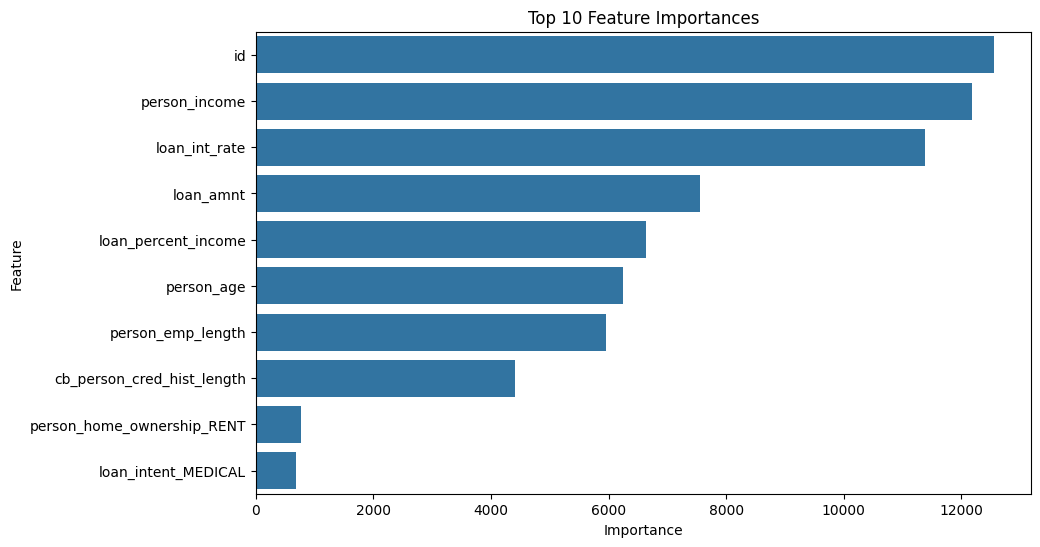

In [22]:
importances = pd.DataFrame({
    'Feature': X_train_all.columns,
    'Importance': final_model.feature_importance()
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances")
plt.show()

python app.py   === run this code in terminal---dont create a new environment